# Imports

In [ ]:
import easydict

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd.variable import Variable

import torchvision
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
plt.ion();

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

# [Vanilla GAN - 2014](https://github.com/ozanciga/gans-with-pytorch/blob/master/gan/gan.py)

## Generative Adversarial Networks
GAN은 단순히 특정한 이미지를 이해하고 분류하는 것을 넘어서 실제 데이터와 흡사한 가짜 데이터를 생성하는 알고리즘입니다.  GAN은 생성자(Generator) 모델과 구분자(Discriminator) 모델로 두 개의 모델이 학습하는 방식으로 동작합니다.    

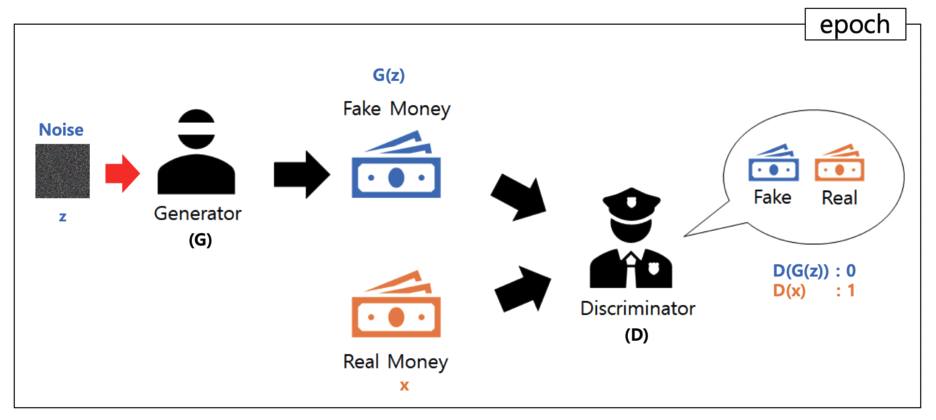

### GAN 학습 과정
1. 구분자 모델은 먼저 진짜 데이터를 진짜로 분류하도록 학습시킵니다.
2. 다음으로 생성자 모델이 생성한 데이터를 가짜로 분류하도록 학습시킵니다.  
3. 마지막으로 학습된 구분자 모델을 속이는 방향으로 생성자 모델을 학습시킵니다.

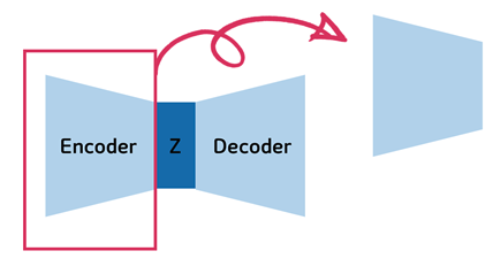

Encoder 부분이 Discriminator 부분이며, Decoder 부분이 Generator가 되는 구조이다.  
- 따라서 Generator는 이미 압축된 저차원의 latent variable의 z가 Generator 네트워크를 통과하게 되면 이미지가 나오게 된다. -> 복원이 되는 것!
- 그러면 방금 복원된 가짜 이미지랑 진짜 이미지(x)가 discriminator network로 들어간다.
- 이때 D(x)라는 것은 진짜 이미지가 들어간 것이고, D(G(z))는 만들어진 가짜 이미지가 들어간 것이다.
- Discriminator의 output이 1이면 real, 0이면 fake라고 예측을 한 것이다.
- 즉 Discriminator가 정확하다면 D(x)는 항상 1이어야하고 D(G(z))는 항상 0이라고 답해야 합니다. -> 그게 Discriminator 목적!

## GAN 모델 구조
- Generator: 가짜 사진을 만드는 네트워크
- Discriminator: 진짜와 가짜를 구분할 수 있는 네트워크

이 두가지 네트워크가 서로 경쟁하는 구조이다.

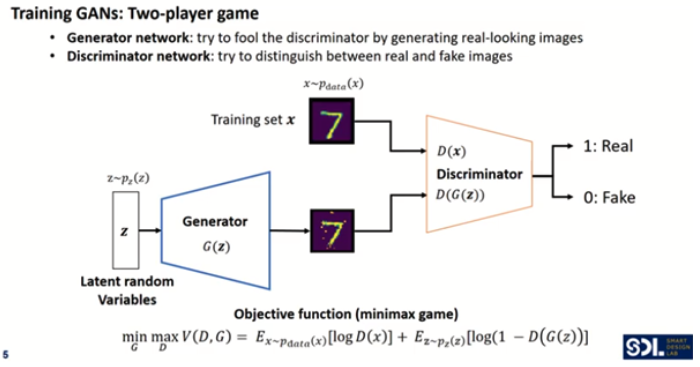

### Objective function / loss function

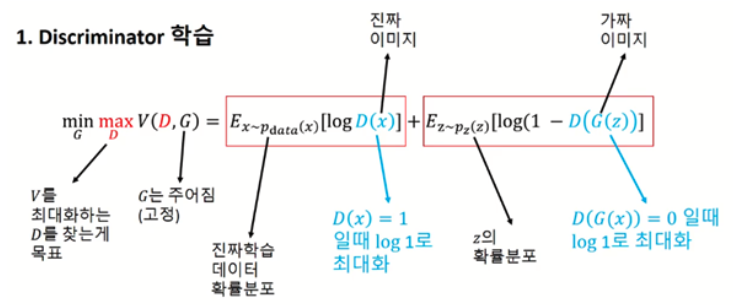

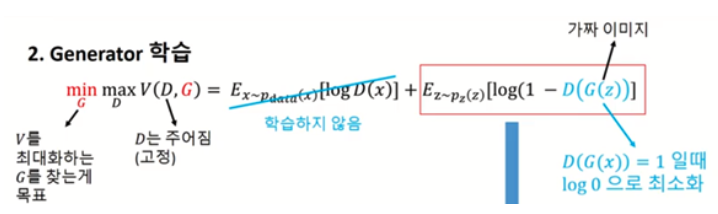

## Model

In [ ]:
opt = easydict.EasyDict()
opt.n_epochs = 200
opt.batch_size = 64
opt.lr = 0.0002
opt.b1 = 0.5
opt.b2 = 0.999
opt.latent_dim = 100
opt.img_size = 28
opt.channels = 1
opt.sample_interval = 512

In [ ]:
img_dims = (opt.channels, opt.img_size, opt.img_size)
n_features = opt.channels * opt.img_size * opt.img_size

img_dims, n_features

((1, 28, 28), 784)

In [ ]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        def ganlayer(n_input, n_output, dropout=True):
            pipeline = [nn.Linear(n_input, n_output)]
            pipeline.append(nn.LeakyReLU(0.2, inplace=True))
            if dropout:
                pipeline.append(nn.Dropout(0.25))
            return pipeline

        self.model = nn.Sequential(
            *ganlayer(opt.latent_dim, 128, dropout=False),
            *ganlayer(128, 256),
            *ganlayer(256, 512),
            *ganlayer(512, 1024),
            nn.Linear(1024, n_features),
            nn.Tanh()
        )
        # Tanh > Image values are between [-1, 1]

    def forward(self, z):
        img = self.model(z)
        img = img.view(img.size(0), *img_dims)
        return img

In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(n_features, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, img):
        flatimg = img.view(img.size(0), -1)
        prob = self.model( flatimg )
        return prob

## MNIST Data

In [ ]:
def mnist_data():
    compose = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((0.5), (0.5))
         ])
    output_dir = './data/mnist'
    return datasets.MNIST(root=output_dir, train=True,
                          transform=compose, download=True)

In [ ]:
mnist = mnist_data()
batch_iterator = DataLoader(mnist, shuffle=True, batch_size=opt.batch_size) # List, NCHW format.

## Train

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
gan_loss = nn.BCELoss()

generator = Generator().to(device)
discriminator = Discriminator().to(device)

optimizer_D = optim.Adam(discriminator.parameters(), lr=opt.lr, betas=(opt.b1, opt.b2))
optimizer_G = optim.Adam(generator.parameters(), lr=opt.lr, betas=(opt.b1, opt.b2))

  0%|          | 0/200 [00:00<?, ?it/s]

EPOCH 0: BATCH: 937, discrim_loss: 0.5570045709609985, generator_loss: 2.4161806106567383


<ipython-input-78-3ae5c0ff5614>:58: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(int('15{}'.format(i+1)))


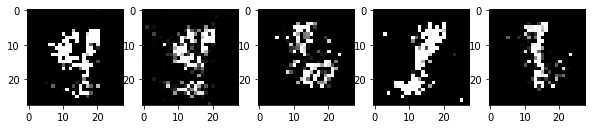

EPOCH 40: BATCH: 937, discrim_loss: 1.0176949501037598, generator_loss: 1.3957908153533936


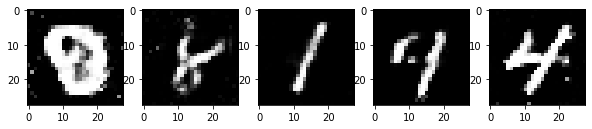

EPOCH 80: BATCH: 937, discrim_loss: 0.7805837392807007, generator_loss: 1.4594156742095947


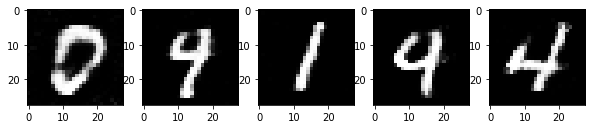

EPOCH 120: BATCH: 937, discrim_loss: 0.7529733180999756, generator_loss: 1.5079059600830078


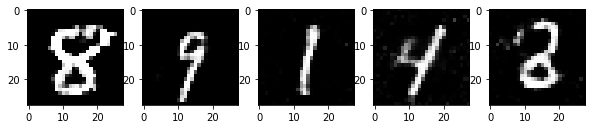

EPOCH 160: BATCH: 937, discrim_loss: 0.9933748841285706, generator_loss: 1.9508516788482666


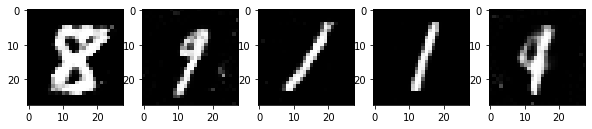

In [ ]:
from tqdm.auto import tqdm

g_losses = []
d_losses = []
testing_random_latent = torch.randn(5, opt.latent_dim).normal_(0, 1).to(device)

for epoch in tqdm(range(opt.n_epochs)):
    # print('Epoch {}'.format(epoch))
    for batch_index, (batch, _) in enumerate(batch_iterator):

        real = torch.ones(batch.size(0), 1, requires_grad=False).to(device)
        fake = torch.zeros(batch.size(0), 1, requires_grad=False).to(device)

        imgs_real = batch.to(device)
        noise = torch.randn(batch.size(0), opt.latent_dim).normal_(0, 1).to(device)
        imgs_fake = Variable(generator(noise), requires_grad=False)


        # == Discriminator update == #
        optimizer_D.zero_grad()

        # A small reminder: given classes c, prob. p, - c*logp - (1-c)*log(1-p) is the BCE/GAN loss.
        # Putting D(x) as p, x=real's class as 1, (..and same for fake with c=0) we arrive to BCE loss.
        # This is intuitively how well the discriminator can distinguish btw real & fake.
        d_loss = gan_loss(discriminator(imgs_real), real) + \
                 gan_loss(discriminator(imgs_fake), fake)

        d_loss.backward()
        optimizer_D.step()


        # == Generator update == #
        noise = torch.randn(batch.size(0), opt.latent_dim).normal_(0, 1).to(device)
        imgs_fake = generator(noise)

        optimizer_G.zero_grad()

        # Minimizing (1-log(d(g(noise))) is less stable than maximizing log(d(g)) [*].
        # Since BCE loss is defined as a negative sum, maximizing [*] is == minimizing [*]'s negative.
        # Intuitively, how well does the G fool the D?
        g_loss = gan_loss(discriminator(imgs_fake), real)

        g_loss.backward()
        optimizer_G.step()

        g_losses.append(g_loss.item())
        d_losses.append(d_loss.item())

    if epoch % 40 == 0:
        print("EPOCH {}: BATCH: {}, discrim_loss: {}, generator_loss: {}".format(epoch, batch_index, d_loss, g_loss))
        with torch.no_grad():
            testing_fake_images = generator(testing_random_latent)
            testing_fake_images = testing_fake_images.reshape(5, 28, 28).cpu().numpy()

            plt.figure(figsize=(10, 5))
            # plt.title("GENERATED IMAGE, EPOCH {}".format(epoch))
            for i in range(5):
                plt.subplot(int('15{}'.format(i+1)))
                plt.imshow(testing_fake_images[i], cmap='gray')
            plt.show()

# [CGAN - 2014](https://github.com/ozanciga/gans-with-pytorch/blob/master/cgan/cgan.py)

## Conditional GAN
- CGAN은 생성자와 판별자가 훈련하는 동안 추가 정보를 사용해 조건이 붙는 생성적 적대 신경망입니다.
- CGAN을 이용하면 우리가 원하는 class가 담긴 데이터를 생성할 수 있습니다.
- 생성자와 판별자를 훈련하는 데 모두 label을 사용합니다.

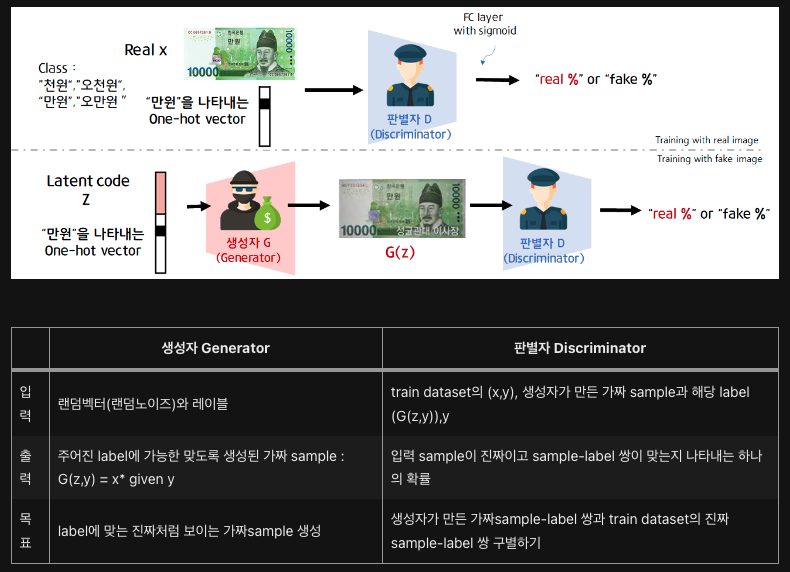

## CGAN 모델 구조

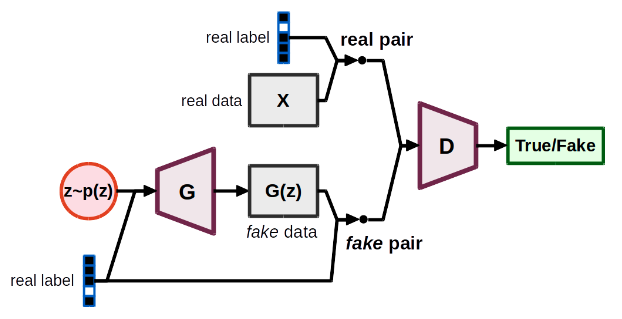

## Model

In [ ]:
opt = easydict.EasyDict()
opt.n_epochs = 400
opt.batch_size = 100
opt.lr = 0.0002
opt.b1 = 0.5
opt.b2 = 0.999
opt.latent_dim = 100
opt.img_size = 28
opt.channels = 1
opt.n_classes = 10
opt.sample_interval = 512

In [ ]:
img_dims = (opt.channels, opt.img_size, opt.img_size)
n_features = opt.channels * opt.img_size * opt.img_size

In [ ]:
def weights_init_xavier(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.xavier_normal_(m.weight.data, gain=0.02)
    elif classname.find('Linear') != -1:
        nn.init.xavier_normal_(m.weight.data, gain=0.02)
    elif classname.find('BatchNorm1d') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0.0)

In [ ]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()

        # Map z & y (noise and label) into the hidden layer.
        # TO DO: How to run this with a function defined here?
        self.z_map = nn.Sequential(
            nn.Linear(opt.latent_dim, 200),
            nn.BatchNorm1d(200),
            nn.ReLU(inplace=True),
        )
        self.y_map = nn.Sequential(
            nn.Linear(opt.n_classes, 1000),
            nn.BatchNorm1d(1000),
            nn.ReLU(inplace=True),
        )
        self.zy_map = nn.Sequential(
            nn.Linear(1200, 1200),
            nn.BatchNorm1d(1200),
            nn.ReLU(inplace=True),
        )

        self.model = nn.Sequential(
            nn.Linear(1200, n_features),
            nn.Tanh()
        )
        # Tanh > Image values are between [-1, 1]


    def forward(self, z, y):
        zh = self.z_map(z)
        yh = self.y_map(y)
        zy = torch.cat((zh, yh), dim=1) # Combine noise and labels.
        zyh = self.zy_map(zy)
        x = self.model(zyh)
        x = x.view(x.size(0), *img_dims)
        return x

In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()

        self.model = nn.Sequential(
            nn.Linear(240, 1),
            nn.Sigmoid()
        )

        # Imitating a 3d array by combining second and third dimensions via multiplication for maxout.
        self.x_map = nn.Sequential(nn.Linear(n_features, 240 * 5))
        self.y_map = nn.Sequential(nn.Linear(opt.n_classes, 50 * 5))
        self.j_map = nn.Sequential(nn.Linear(240 + 50, 240 * 4))

    def forward(self, x, y):
        # maxout for x
        x = x.view(-1, n_features)
        x = self.x_map(x)
        x, _ = x.view(-1, 240, 5).max(dim=2) # pytorch outputs max values and indices
        # .. and y
        y = y.view(-1, opt.n_classes)
        y = self.y_map(y)
        y, _ = y.view(-1, 50, 5).max(dim=2)
        # joint maxout layer
        jmx = torch.cat((x, y), dim=1)
        jmx = self.j_map(jmx)
        jmx, _ = jmx.view(-1, 240, 4).max(dim=2)

        prob = self.model(jmx)
        return prob

## MNIST Data

In [ ]:
def mnist_data():
    compose = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((0.5), (0.5))
         ])
    output_dir = './data/mnist'
    return datasets.MNIST(root=output_dir, train=True,
                          transform=compose, download=True)

In [ ]:
mnist = mnist_data()
batch_iterator = DataLoader(mnist, shuffle=True, batch_size=opt.batch_size) # List, NCHW format.

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/mnist/MNIST/raw/train-images-idx3-ubyte.gz to ./data/mnist/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/mnist/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/mnist/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/mnist/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/mnist/MNIST/raw



## Train

In [ ]:
generator = Generator().to(device)
discriminator = Discriminator().to(device)

# Weight initialization.
generator.apply(weights_init_xavier)
discriminator.apply(weights_init_xavier)

Discriminator(
  (model): Sequential(
    (0): Linear(in_features=240, out_features=1, bias=True)
    (1): Sigmoid()
  )
  (x_map): Sequential(
    (0): Linear(in_features=784, out_features=1200, bias=True)
  )
  (y_map): Sequential(
    (0): Linear(in_features=10, out_features=250, bias=True)
  )
  (j_map): Sequential(
    (0): Linear(in_features=290, out_features=960, bias=True)
  )
)

In [ ]:
gan_loss = nn.BCELoss()

optimizer_D = optim.Adam(discriminator.parameters(), lr=opt.lr, betas=(opt.b1, opt.b2))
optimizer_G = optim.Adam(generator.parameters(), lr=opt.lr, betas=(opt.b1, opt.b2))

  0%|          | 0/500 [00:00<?, ?it/s]

EPOCH 0: BATCH: 599, discrim_loss: 1.3680541515350342, generator_loss: 0.7353429794311523
labels: [4, 4, 8, 6, 6]


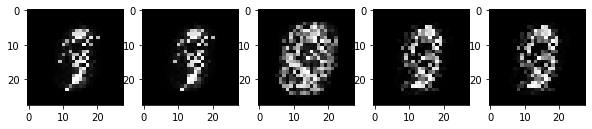

EPOCH 40: BATCH: 599, discrim_loss: 0.9371869564056396, generator_loss: 1.8489534854888916
labels: [8, 5, 3, 6, 3]


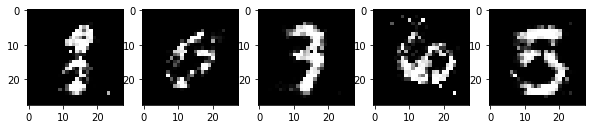

EPOCH 80: BATCH: 599, discrim_loss: 0.6431202292442322, generator_loss: 2.298041343688965
labels: [2, 2, 8, 0, 6]


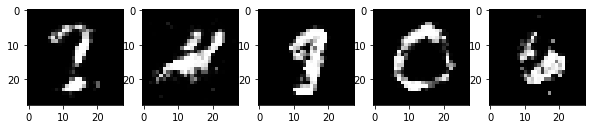

EPOCH 120: BATCH: 599, discrim_loss: 0.691767156124115, generator_loss: 2.1806912422180176
labels: [1, 2, 5, 7, 3]


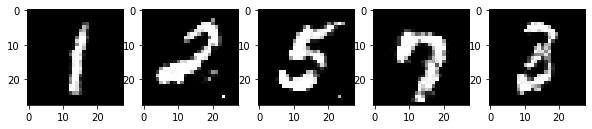

EPOCH 160: BATCH: 599, discrim_loss: 0.5822690725326538, generator_loss: 2.2215652465820312
labels: [3, 7, 1, 3, 1]


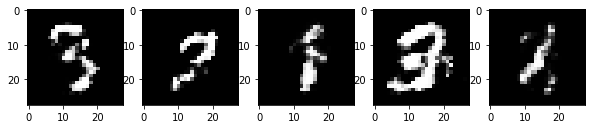

EPOCH 200: BATCH: 599, discrim_loss: 0.6256793737411499, generator_loss: 3.76949143409729
labels: [4, 4, 0, 8, 8]


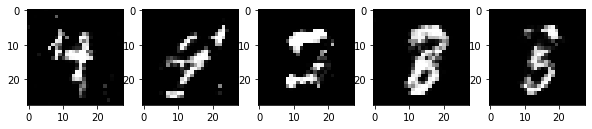

EPOCH 240: BATCH: 599, discrim_loss: 0.5615583658218384, generator_loss: 3.490786552429199
labels: [0, 4, 9, 0, 8]


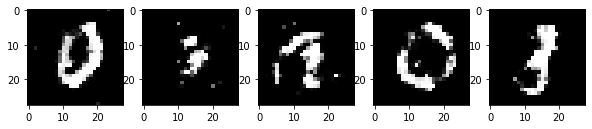

EPOCH 280: BATCH: 599, discrim_loss: 0.440374493598938, generator_loss: 4.405646324157715
labels: [0, 5, 7, 0, 7]


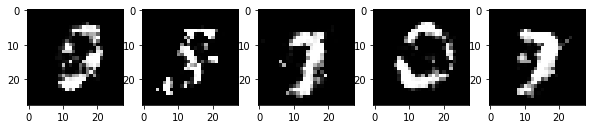

EPOCH 320: BATCH: 599, discrim_loss: 0.5071746110916138, generator_loss: 4.455108642578125
labels: [6, 3, 3, 6, 2]


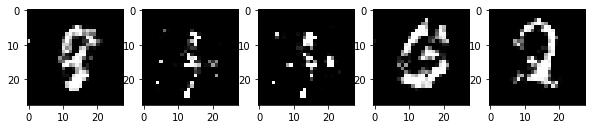

EPOCH 360: BATCH: 599, discrim_loss: 0.4737051725387573, generator_loss: 4.934362888336182
labels: [7, 6, 4, 9, 3]


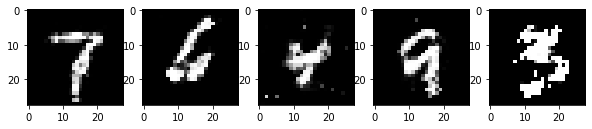

EPOCH 400: BATCH: 599, discrim_loss: 0.415937215089798, generator_loss: 6.9413628578186035
labels: [8, 8, 5, 8, 7]


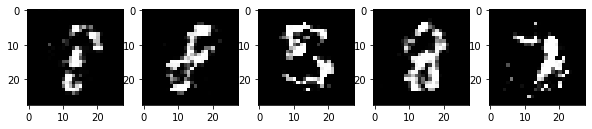

EPOCH 440: BATCH: 599, discrim_loss: 0.40119993686676025, generator_loss: 6.599946022033691
labels: [1, 6, 3, 9, 4]


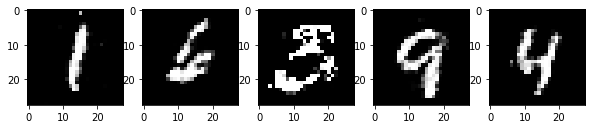

EPOCH 480: BATCH: 599, discrim_loss: 0.44449910521507263, generator_loss: 4.8663787841796875
labels: [5, 8, 8, 4, 8]


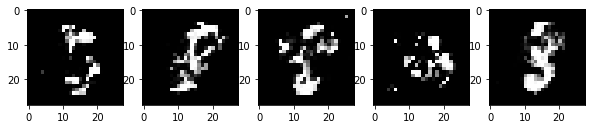

In [ ]:
from tqdm.auto import tqdm

g_losses = []
d_losses = []
testing_random_latent = torch.randn(5, opt.latent_dim).normal_(0, 1).to(device)

for epoch in tqdm(range(opt.n_epochs)):
    for batch_index, (batch, labels) in enumerate(batch_iterator):

        real = torch.ones(batch.size(0), 1, requires_grad=False).to(device)
        fake = torch.zeros(batch.size(0), 1, requires_grad=False).to(device)

        labels_onehot = torch.zeros(batch.size(0), opt.n_classes).to(device)
        labels_ = labels.long().to(device) # Note: MNIST dataset is given as a longtensor, and we use .type() to feed it into cuda (if cuda available).
        labels_ = labels_.view(batch.size(0), 1)
        labels_onehot = labels_onehot.scatter_(1, labels_, 1) # As of 0.4, we don't have one-hot built-in function yet in pytorch.

        imgs_real = batch.to(device)
        noise = torch.randn(batch.size(0), opt.latent_dim).normal_(0, 1).to(device)
        imgs_fake = generator(noise, labels_onehot)

        # == Discriminator update == #
        optimizer_D.zero_grad()

        # A small reminder: given classes c, prob. p, - c*logp - (1-c)*log(1-p) is the BCE/GAN loss.
        # Putting D(x) as p, x=real's class as 1, (..and same for fake with c=0) we arrive to BCE loss.
        # This is intuitively how well the discriminator can distinguish btw real & fake.
        d_loss = gan_loss(discriminator(imgs_real, labels_onehot), real) + \
                 gan_loss(discriminator(imgs_fake, labels_onehot), fake)

        d_loss.backward()
        optimizer_D.step()


        # == Generator update == #
        noise = torch.randn(batch.size(0), opt.latent_dim).normal_(0, 1).to(device)
        imgs_fake = generator(noise, labels_onehot)

        optimizer_G.zero_grad()

        # Minimizing (1-log(d(g(noise))) is less stable than maximizing log(d(g)) [*].
        # Since BCE loss is defined as a negative sum, maximizing [*] is == minimizing [*]'s negative.
        # Intuitively, how well does the G fool the D?
        g_loss = gan_loss(discriminator(imgs_fake, labels_onehot), real)

        g_loss.backward()
        optimizer_G.step()

        g_losses.append(g_loss.item())
        d_losses.append(d_loss.item())

    if epoch % 40 == 0:
        print("EPOCH {}: BATCH: {}, discrim_loss: {}, generator_loss: {}".format(epoch, batch_index, d_loss, g_loss))
        labels = labels_onehot[:5]
        labels_topk = labels.topk(1)[1].reshape(-1).tolist()
        print(f"labels: {labels_topk}")
        with torch.no_grad():
            testing_fake_images = generator(testing_random_latent, labels)
            testing_fake_images = testing_fake_images.reshape(5, 28, 28).cpu().numpy()

            plt.figure(figsize=(10, 5))
            # plt.title("GENERATED IMAGE, EPOCH {}".format(epoch))
            for i in range(5):
                plt.subplot(int('15{}'.format(i+1)))
                plt.imshow(testing_fake_images[i], cmap='gray')
            plt.show()


# [pix2pix](https://pseudo-lab.github.io/Tutorial-Book/chapters/GAN/Ch4-pix2pix.html)

In [26]:
import os
import glob
import numpy as np
import datetime
import matplotlib.pyplot as plt
from PIL import Image

from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision.utils import save_image
import torch.nn as nn
import torch.nn.functional as F
import torch
import torchvision
from torch.autograd import Variable

In [28]:
root = ''

batch_size = 12
img_height = 256
img_width = 256

## Download Data

In [25]:
!git clone https://github.com/Pseudo-Lab/Tutorial-Book-Utils
!python Tutorial-Book-Utils/PL_data_loader.py --data GAN-Colorization
!unzip -q Victorian400-GAN-colorization-data.zip

Cloning into 'Tutorial-Book-Utils'...
remote: Enumerating objects: 45, done.
remote: Counting objects: 100% (45/45), done.
remote: Compressing objects: 100% (39/39), done.
remote: Total 45 (delta 18), reused 17 (delta 5), pack-reused 0
Receiving objects: 100% (45/45), 11.62 KiB | 5.81 MiB/s, done.
Resolving deltas: 100% (18/18), done.
Downloading...
From: https://drive.google.com/uc?id=1dZxoBIWmbuF-Oy_XZoS1z9EjPJwkTmy6
To: /content/Victorian400-GAN-colorization-data.zip
100% 508M/508M [00:10<00:00, 48.1MB/s]
Victorian400-GAN-colorization-data.zip download complete!


## Dataset

In [27]:
class VictorianDataset(Dataset):
    def __init__(self, root, color_transforms_=None, gray_transforms_=None):

        self.color_transforms = transforms.Compose(color_transforms_)
        self.gray_transforms = transforms.Compose(gray_transforms_)
        self.gray_files = sorted(glob.glob(os.path.join(root, 'gray') + "/*.*"))
        self.color_files = sorted(glob.glob(os.path.join(root, 'resized') + "/*.*"))

    def __getitem__(self, index):
        gray_img = Image.open(self.gray_files[index % len(self.gray_files)]).convert("RGB")
        color_img = Image.open(self.color_files[index % len(self.color_files)]).convert("RGB")

        gray_img = self.gray_transforms(gray_img)
        color_img = self.color_transforms(color_img)

        return {"A": gray_img, "B": color_img}

    def __len__(self):
        return len(self.gray_files)

In [29]:
color_mean = [0.58090717, 0.52688643, 0.45678478]
color_std = [0.25644188, 0.25482641, 0.24456465]
gray_mean = [0.5350533, 0.5350533, 0.5350533]
gray_std = [0.25051587, 0.25051587, 0.25051587]

color_transforms_ = [
    transforms.ToTensor(),
    transforms.Normalize(mean=color_mean, std=color_std),
]

gray_transforms_ = [
    transforms.ToTensor(),
    transforms.Normalize(mean=gray_mean, std=gray_std),
]

## DataLoader

In [30]:
train_loader  = DataLoader(
    VictorianDataset(root, color_transforms_=color_transforms_, gray_transforms_=gray_transforms_),
    batch_size=batch_size,
    shuffle=True
)

In [31]:
def reNormalize(img, mean, std):
    img = img.numpy().transpose(1, 2, 0)
    img = img * std + mean
    img = img.clip(0, 1)
    return img

torch.Size([12, 3, 256, 256]) torch.Size([12, 3, 256, 256])


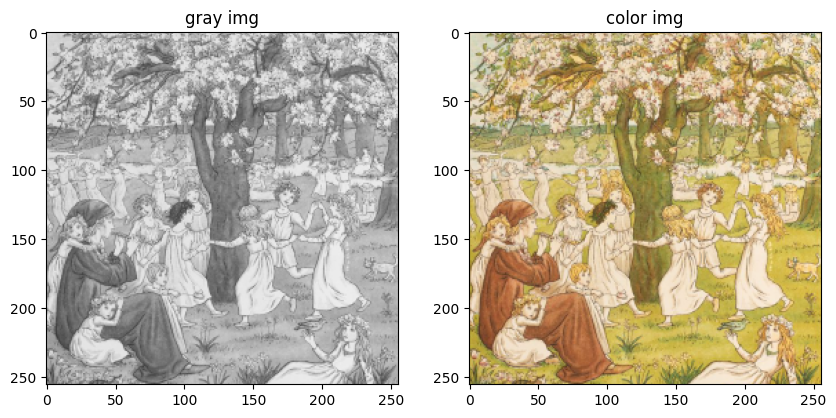

In [32]:
fig = plt.figure(figsize=(10, 5))
rows = 1
cols = 2

for X in train_loader :

    print(X['A'].shape, X['B'].shape)
    ax1 = fig.add_subplot(rows, cols, 1)
    ax1.imshow(reNormalize(X["A"][0], gray_mean, gray_std))
    ax1.set_title('gray img')

    ax2 = fig.add_subplot(rows, cols, 2)
    ax2.imshow(reNormalize(X["B"][0], color_mean, color_std))
    ax2.set_title('color img')

    plt.show()
    break

## [Model](https://developers.arcgis.com/python/guide/how-pix2pix-works/)
- pix2pix의 특징은 일반적인 인코더-디코더(Encoder-Decoder)보다는 U-NET을 사용합니다.
- U-NET의 특징은 일반적인 인코더-디코더와 달리 스킵 커넥션 (Skip Connections)이 있어, 인코더 레이어와 디코더 레이어 간의 연결을 보다 로컬라이징(localization)을 잘 해주는 특징이 있습니다.
- 예를 들어, 첫 인코더 레이어 크기가 256 x 256 x 3이라면, 마지막 디코더 레이어 크기도 똑같이 256 x 256 x 3이게 됩니다.
- 이렇게 같은 크기의 인코더-디코더 레이어가 결합하여, 보다 효과적이고 빠른 성능을 발휘할 수 있게 하는게 U-NET의 특징입니다.

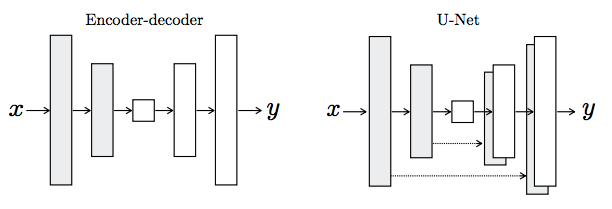

In [33]:
def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm2d") != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0.0)

# U-NET 생성

class UNetDown(nn.Module):
    def __init__(self, in_size, out_size, normalize=True, dropout=0.0):
        super(UNetDown, self).__init__()
        layers = [nn.Conv2d(in_size, out_size, 4, 2, 1, bias=False)]
        if normalize:
            layers.append(nn.InstanceNorm2d(out_size))
        layers.append(nn.LeakyReLU(0.2))
        if dropout:
            layers.append(nn.Dropout(dropout))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)


class UNetUp(nn.Module):
    def __init__(self, in_size, out_size, dropout=0.0):
        super(UNetUp, self).__init__()
        layers = [
            nn.ConvTranspose2d(in_size, out_size, 4, 2, 1, bias=False),
            nn.InstanceNorm2d(out_size),
            nn.ReLU(inplace=True),
        ]
        if dropout:
            layers.append(nn.Dropout(dropout))

        self.model = nn.Sequential(*layers)

    def forward(self, x, skip_input):
        x = self.model(x)
        x = torch.cat((x, skip_input), 1)

        return x


In [34]:
class GeneratorUNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=3):
        super(GeneratorUNet, self).__init__()

        self.down1 = UNetDown(in_channels, 64, normalize=False)
        self.down2 = UNetDown(64, 128)
        self.down3 = UNetDown(128, 256)
        self.down4 = UNetDown(256, 512, dropout=0.5)
        self.down5 = UNetDown(512, 512, dropout=0.5)
        self.down6 = UNetDown(512, 512, dropout=0.5)
        self.down7 = UNetDown(512, 512, dropout=0.5)
        self.down8 = UNetDown(512, 512, normalize=False, dropout=0.5)

        self.up1 = UNetUp(512, 512, dropout=0.5)
        self.up2 = UNetUp(1024, 512, dropout=0.5)
        self.up3 = UNetUp(1024, 512, dropout=0.5)
        self.up4 = UNetUp(1024, 512, dropout=0.5)
        self.up5 = UNetUp(1024, 256)
        self.up6 = UNetUp(512, 128)
        self.up7 = UNetUp(256, 64)

        self.final = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.ZeroPad2d((1, 0, 1, 0)),
            nn.Conv2d(128, out_channels, 4, padding=1),
            nn.Tanh(),
        )

    def forward(self, x):
        # U-Net generator with skip connections from encoder to decoder
        d1 = self.down1(x)
        d2 = self.down2(d1)
        d3 = self.down3(d2)
        d4 = self.down4(d3)
        d5 = self.down5(d4)
        d6 = self.down6(d5)
        d7 = self.down7(d6)
        d8 = self.down8(d7)
        u1 = self.up1(d8, d7)
        u2 = self.up2(u1, d6)
        u3 = self.up3(u2, d5)
        u4 = self.up4(u3, d4)
        u5 = self.up5(u4, d3)
        u6 = self.up6(u5, d2)
        u7 = self.up7(u6, d1)

        return self.final(u7)

In [35]:
class Discriminator(nn.Module):
    def __init__(self, in_channels=3):
        super(Discriminator, self).__init__()

        def discriminator_block(in_filters, out_filters, normalization=True):
            """Returns downsampling layers of each discriminator block"""
            layers = [nn.Conv2d(in_filters, out_filters, 4, stride=2, padding=1)]
            if normalization:
                layers.append(nn.InstanceNorm2d(out_filters))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *discriminator_block(in_channels * 2, 64, normalization=False),
            *discriminator_block(64, 128),
            *discriminator_block(128, 256),
            *discriminator_block(256, 512),
            nn.ZeroPad2d((1, 0, 1, 0)),
            nn.Conv2d(512, 1, 4, padding=1, bias=False)
        )

    def forward(self, img_A, img_B):
        # Concatenate image and condition image by channels to produce input
        img_input = torch.cat((img_A, img_B), 1)
        return self.model(img_input)

In [36]:
GeneratorUNet().apply(weights_init_normal)

GeneratorUNet(
  (down1): UNetDown(
    (model): Sequential(
      (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): LeakyReLU(negative_slope=0.2)
    )
  )
  (down2): UNetDown(
    (model): Sequential(
      (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (2): LeakyReLU(negative_slope=0.2)
    )
  )
  (down3): UNetDown(
    (model): Sequential(
      (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (2): LeakyReLU(negative_slope=0.2)
    )
  )
  (down4): UNetDown(
    (model): Sequential(
      (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): InstanceNorm2d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=Fals

In [37]:
Discriminator().apply(weights_init_normal)

Discriminator(
  (model): Sequential(
    (0): Conv2d(6, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (6): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (9): InstanceNorm2d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): ZeroPad2d((1, 0, 1, 0))
    (12): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1), bias=False)
  )
)

## Training

In [38]:
n_epochs = 100
dataset_name = "Victorian400"
lr = 0.0002
b1 = 0.5                    # adam: decay of first order momentum of gradient
b2 = 0.999                  # adam: decay of first order momentum of gradient
decay_epoch = 100           # epoch from which to start lr decay
#n_cpu = 8                   # number of cpu threads to use during batch generation
channels = 3                # number of image channels
checkpoint_interval = 20    # interval between model checkpoints

In [39]:
os.makedirs("images/%s/val" % dataset_name, exist_ok=True)
os.makedirs("images/%s/test" % dataset_name, exist_ok=True)
os.makedirs("saved_models/%s" % dataset_name, exist_ok=True)

# Loss functions
criterion_GAN = torch.nn.MSELoss()
criterion_pixelwise = torch.nn.L1Loss()

# Loss weight of L1 pixel-wise loss between translated image and real image
lambda_pixel = 100

# Calculate output of image discriminator (PatchGAN)
patch = (1, img_height // 2 ** 4, img_width // 2 ** 4)

# Initialize generator and discriminator
generator = GeneratorUNet()
discriminator = Discriminator()

cuda = True if torch.cuda.is_available() else False

if cuda:
    generator = generator.cuda()
    discriminator = discriminator.cuda()
    criterion_GAN.cuda()
    criterion_pixelwise.cuda()

# Optimizers
optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(b1, b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(b1, b2))

# Tensor type
Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

In [40]:
def sample_images(epoch, loader, mode):
    imgs = next(iter(loader))
    gray = Variable(imgs["A"].type(Tensor))
    color = Variable(imgs["B"].type(Tensor))
    output = generator(gray)

    gray_img = torchvision.utils.make_grid(gray.data, nrow=6)
    color_img = torchvision.utils.make_grid(color.data, nrow=6)
    output_img = torchvision.utils.make_grid(output.data, nrow=6)

    rows = 3
    cols = 1

    ax1 = fig.add_subplot(rows, cols, 1)
    ax1.imshow(reNormalize(gray_img.cpu(), gray_mean, gray_std))
    ax1.set_title('gray')

    ax2 = fig.add_subplot(rows, cols, 2)
    ax2.imshow(reNormalize(color_img.cpu(), color_mean, color_std))
    ax2.set_title('color')

    ax3 = fig.add_subplot(rows, cols, 3)
    ax3.imshow(reNormalize(output_img.cpu(), color_mean, color_std))
    ax3.set_title('output')

    plt.show()
    fig.savefig("images/%s/%s/epoch_%s.png" % (dataset_name, mode, epoch), pad_inches=0)

In [42]:
from tqdm.auto import tqdm
# ----------
#  Training
# ----------

for epoch in tqdm(range(1, n_epochs+1)):
    start_time = datetime.datetime.now()
    for i, batch in enumerate(train_loader):

        # Model inputs
        gray = Variable(batch["A"].type(Tensor))
        color = Variable(batch["B"].type(Tensor))

        # Adversarial ground truths
        valid = Variable(Tensor(np.ones((gray.size(0), *patch))), requires_grad=False)
        fake = Variable(Tensor(np.zeros((gray.size(0), *patch))), requires_grad=False)

        # ------------------
        #  Train Generators
        # ------------------

        optimizer_G.zero_grad()

        # GAN loss
        output = generator(gray)
        pred_fake = discriminator(output, gray)
        loss_GAN = criterion_GAN(pred_fake, valid)
        # Pixel-wise loss
        loss_pixel = criterion_pixelwise(output, color)

        # Total loss
        loss_G = loss_GAN + lambda_pixel * loss_pixel

        loss_G.backward()

        optimizer_G.step()

        # ---------------------
        #  Train Discriminator
        # ---------------------

        optimizer_D.zero_grad()

        # Real loss
        pred_real = discriminator(color, gray)
        loss_real = criterion_GAN(pred_real, valid)

        # Fake loss
        pred_fake = discriminator(output.detach(), gray)
        loss_fake = criterion_GAN(pred_fake, fake)

        # Total loss
        loss_D = 0.5 * (loss_real + loss_fake)

        loss_D.backward()
        optimizer_D.step()

        epoch_time = datetime.datetime.now() - start_time

    if (epoch) % checkpoint_interval == 0:
        fig = plt.figure(figsize=(18, 18))
        sample_images(epoch, train_loader, 'val')

        torch.save(generator.state_dict(), "saved_models/%s/generator_%d.pth" % (dataset_name, epoch))
        torch.save(discriminator.state_dict(), "saved_models/%s/discriminator_%d.pth" % (dataset_name, epoch))

        print("[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f, pixel: %f, adv: %f] ETA: %s" % (epoch,
                                                                                                    n_epochs,
                                                                                                    i+1,
                                                                                                    len(train_loader),
                                                                                                    loss_D.item(),
                                                                                                    loss_G.item(),
                                                                                                    loss_pixel.item(),
                                                                                                    loss_GAN.item(),
                                                                                                    epoch_time))


Output hidden; open in https://colab.research.google.com to view.

## Prediction

In [43]:
test_root = root + 'test/'
test_batch_size = 6

test_loader = DataLoader(
    VictorianDataset(test_root, color_transforms_=color_transforms_, gray_transforms_=gray_transforms_),
    batch_size=test_batch_size,
    shuffle=False
)

torch.Size([6, 3, 256, 256]) torch.Size([6, 3, 256, 256])


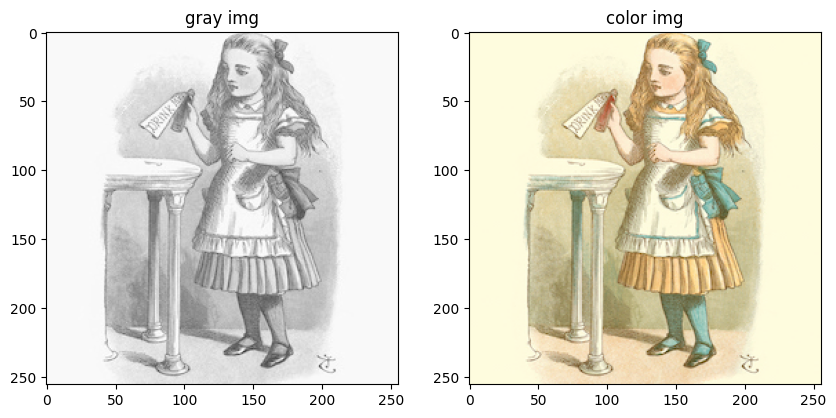

In [44]:
fig = plt.figure(figsize=(10, 5))
rows = 1
cols = 2

for X in test_loader:

    print(X['A'].shape, X['B'].shape)
    ax1 = fig.add_subplot(rows, cols, 1)
    ax1.imshow(reNormalize(X["A"][0], gray_mean, gray_std))
    ax1.set_title('gray img')

    ax2 = fig.add_subplot(rows, cols, 2)
    ax2.imshow(reNormalize(X["B"][0], color_mean, color_std))
    ax2.set_title('color img')

    plt.show()
    break

In [45]:
generator.load_state_dict(torch.load("saved_models/%s/generator_%d.pth" % (dataset_name, n_epochs)))
discriminator.load_state_dict(torch.load("saved_models/%s/discriminator_%d.pth" % (dataset_name, n_epochs)))

<All keys matched successfully>

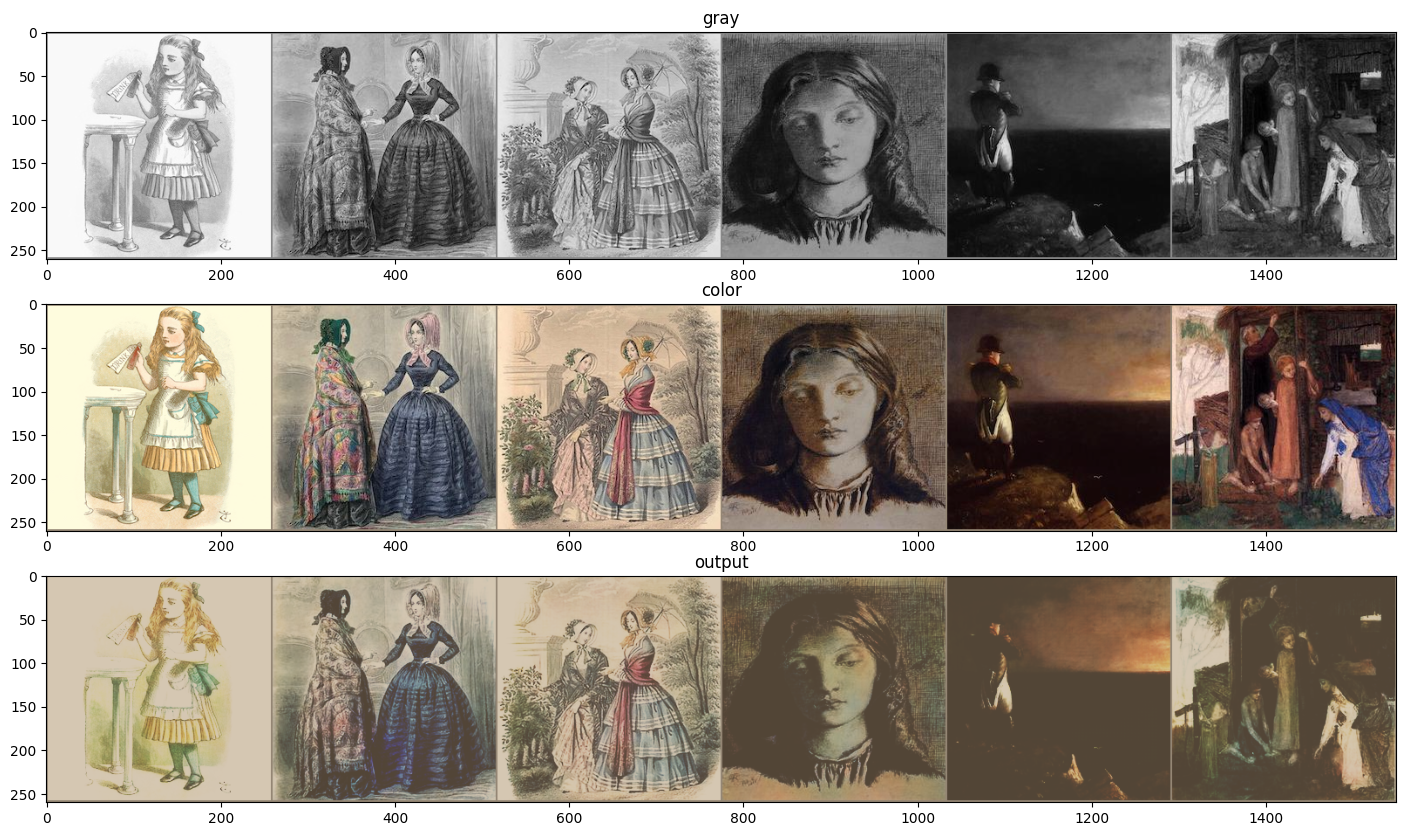

In [46]:
generator.eval()
discriminator.eval()

fig = plt.figure(figsize=(18,10))
sample_images(n_epochs, test_loader, 'test')